In [ ]:
import os
import random
import shutil
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# для колаба
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DIR = 'gdrive/MyDrive/'
# если локально
# DIR = ''
# подгрузим данные
# напомню, что identity_CelebA_mini.csv содержит данные по 200 наиболее часто встречающимся классам
filtered_identity_csv = f"{DIR}identity_CelebA_mini.csv"
filtered_identity_df = pd.read_csv(filtered_identity_csv)
filtered_identity_df

,image_id,id
0,000001.jpg,2880
1,000096.jpg,4262
2,000116.jpg,4887
3,000150.jpg,6568
4,000404.jpg,2880
...,...,...
6033,200678.jpg,9256
6034,200853.jpg,9256
6035,201865.jpg,9256
6036,201873.jpg,9256


In [ ]:
# также как и в предыдущем ноутбуке идет разбивка на train/test/val и перенос файлов из aligned_images
import os
from sklearn.model_selection import train_test_split
import shutil

# разобьем данные на train/val/test. Чтобы в каждое разбиение попали все классы, использую stratify
train_val_identity_df, test_identity_df = train_test_split(filtered_identity_df, test_size=0.1, stratify=filtered_identity_df['id'], random_state=42)
train_identity_df, val_identity_df = train_test_split(train_val_identity_df, test_size=0.1, stratify=train_val_identity_df['id'], random_state=42)

In [ ]:
# напомню, что aligned_images.zip - это картинки, обработанные и выровненные с помощью Stacked_Hourglass_Network в ноубуке 1
# !unzip -q aligned_images.zip

In [ ]:
os.makedirs('classification_data/train', exist_ok=True)
os.makedirs('classification_data/val', exist_ok=True)
os.makedirs('classification_data/test', exist_ok=True)

In [ ]:
# функция для перемещения файлов
def move_files(df, source_dir, dest_dir):
    for _, row in df.iterrows():
        src = os.path.join(source_dir, row['image_id'])
        dest = os.path.join(dest_dir, row['image_id'])
        shutil.copy(src, dest)  

move_files(train_identity_df, 'aligned_images', 'classification_data/train')
move_files(val_identity_df, 'aligned_images', 'classification_data/val')
move_files(test_identity_df, 'aligned_images', 'classification_data/test')

In [ ]:
# реализация Dataset для триплетов
from PIL import Image

class FaceDataset(Dataset):
    def __init__(self, images_dir, df_labels, mode='train'):
        self.images_dir = images_dir
        self.df_labels = df_labels.reset_index(drop=True)
        self.mode = mode
        self.class_to_indices = {}
        for idx, row in self.df_labels.iterrows():
            class_label = row['id']
            if class_label not in self.class_to_indices:
                self.class_to_indices[class_label] = []
            self.class_to_indices[class_label].append(idx)

    def __len__(self):
        return len(self.df_labels)

    def __getitem__(self, idx):
        # получаем данные по по anchor
        anchor_row = self.df_labels.iloc[idx]
        anchor_image_path = os.path.join(self.images_dir, anchor_row['image_id'])
        anchor_class = anchor_row['id']

        # вычисляем positive
        positive_index = random.choice(self.class_to_indices[anchor_class])
        while positive_index == idx:  # Убедиться, что Positive не совпадает с Anchor
            positive_index = random.choice(self.class_to_indices[anchor_class])
        positive_image_path = os.path.join(self.images_dir, self.df_labels.iloc[positive_index]['image_id'])

        # вычисляем negative
        negative_class = random.choice([cls for cls in self.class_to_indices.keys() if cls != anchor_class])
        negative_index = random.choice(self.class_to_indices[negative_class])
        negative_image_path = os.path.join(self.images_dir, self.df_labels.iloc[negative_index]['image_id'])

        # грузим, обрабатываем, возвращаем triplet
        anchor_image = Image.open(anchor_image_path).convert("RGB")
        positive_image = Image.open(positive_image_path).convert("RGB")
        negative_image = Image.open(negative_image_path).convert("RGB")
        
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        # для test и val только нормализация и приведение к размеру
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        if self.mode == 'val' or self.mode == 'test':
            anchor_image = transform_test(anchor_image)
            positive_image = transform_test(positive_image)
            negative_image = transform_test(negative_image)
        else:
            anchor_image = transform_train(anchor_image)
            positive_image = transform_train(positive_image)
            negative_image = transform_train(negative_image)

        return anchor_image, positive_image, negative_image

In [ ]:
from torchvision import transforms
# формируем датасеты и даталоадеры для всех этапов
TRAIN_DIR = 'classification_data/train'
VAL_DIR = 'classification_data/val'
TEST_DIR = 'classification_data/test'

train_dataset = FaceDataset(TRAIN_DIR, train_identity_df, mode='train')
val_dataset = FaceDataset(VAL_DIR, val_identity_df, mode='val')
test_dataset = FaceDataset(TEST_DIR, test_identity_df, mode='test')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#посмотрим на данные
anchors, positives, negatives = next(iter(val_loader))
anchor = anchors[0]
positive = positives[0]
negative = negatives[0]

In [ ]:
# функция для рисования картинки
def imshow(inp, title=None):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

# функция для рисования tripleta
def show_images_row(images, titles=None):
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])

    plt.figure(figsize=(12, 4))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        img = images[i]
        img = img.numpy().transpose(1, 2, 0)
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

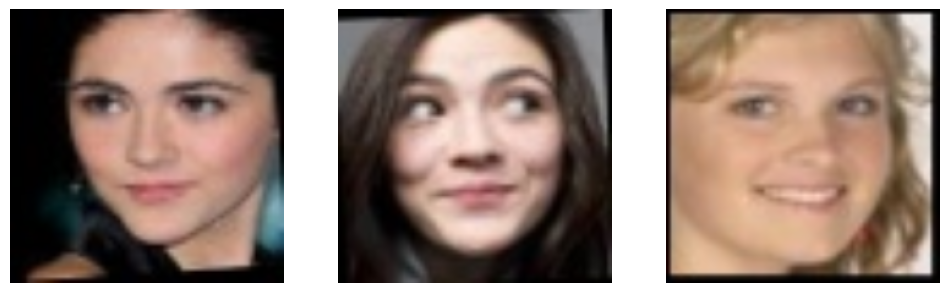

In [ ]:
# посмотрим на данные
show_images_row([anchor, positive, negative])
# видно, что они корректны: первые 2 к одному человеку, 3 - к другому

In [ ]:
embedding_size = 256
from torchvision import models

# модель для TripletLoss
base_model = models.resnet18(pretrained=True)
# заменяем последний слой
base_model.fc = nn.Sequential(
    nn.Linear(512, embedding_size),
    nn.BatchNorm1d(embedding_size),
    nn.ReLU()
)
# Размораживаем слои по аналогии как это было для ArcFace и CrossEntropy
for name, param in base_model.named_parameters():
    param.requires_grad = False
for name, param in base_model.layer3.named_parameters():
    param.requires_grad = True
for name, param in base_model.layer4.named_parameters():
    param.requires_grad = True
for name, param in base_model.fc.named_parameters():
    param.requires_grad = True

# смотрим, что разморожено все, как планировалось
for name, param in base_model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]

conv1.weight: requires_grad = False
bn1.weight: requires_grad = False
bn1.bias: requires_grad = False
layer1.0.conv1.weight: requires_grad = False
layer1.0.bn1.weight: requires_grad = False
layer1.0.bn1.bias: requires_grad = False
layer1.0.conv2.weight: requires_grad = False
layer1.0.bn2.weight: requires_grad = False
layer1.0.bn2.bias: requires_grad = False
layer1.1.conv1.weight: requires_grad = False
layer1.1.bn1.weight: requires_grad = False
layer1.1.bn1.bias: requires_grad = False
layer1.1.conv2.weight: requires_grad = False
layer1.1.bn2.weight: requires_grad = False
layer1.1.bn2.bias: requires_grad = False
layer2.0.conv1.weight: requires_grad = False
layer2.0.bn1.weight: requires_grad = False
layer2.0.bn1.bias: requires_grad = False
layer2.0.conv2.weight: requires_grad = False
layer2.0.bn2.weight: requires_grad = False
layer2.0.bn2.bias: requires_grad = False
layer2.0.downsample.0.weight: requires_grad = False
layer2.0.downsample.1.weight: requires_grad = False
layer2.0.downsample.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# реализация TripletLoss
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = torch.sum((anchor - positive) ** 2, dim=1)
        neg_distance = torch.sum((anchor - negative) ** 2, dim=1)
        loss = torch.relu(pos_distance - neg_distance + self.margin)

        return loss.mean()

In [ ]:
from tqdm import tqdm, tqdm_notebook
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
import seaborn as sns

# фунция для подсчета корретных триплетов (d(A,P) + margin < d(A,N), используется для расчет Triplet Accuracy
def get_correct_triplet_count(anchor, positive, negative, margin):
    anchor = nn.functional.normalize(anchor, p=2, dim=1)
    positive = nn.functional.normalize(positive, p=2, dim=1)
    negative = nn.functional.normalize(negative, p=2, dim=1)

    d_ap = torch.norm(anchor - positive, dim=1, p=2)
    d_an = torch.norm(anchor - negative, dim=1, p=2)
    correct_triplets_count = (d_ap + margin < d_an).sum().item()

    return correct_triplets_count

# функция для обучения эпохи
def fit_epoch(model, train_loader, optimizer, criterion, margin=0.2):
    model.train()
    epoch_loss = 0
    for anchor, positive, negative in train_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)

        anchor_embed = nn.functional.normalize(anchor_embed, p=2, dim=1)
        positive_embed = nn.functional.normalize(positive_embed, p=2, dim=1)
        negative_embed = nn.functional.normalize(negative_embed, p=2, dim=1)

        loss = criterion(anchor_embed, positive_embed, negative_embed)
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    return epoch_loss / len(train_loader)

# функция для валидации эпохи
def eval_epoch(model, val_loader, margin=0.2):
    model.eval()
    processed_size = 0
    total_correct_triplets = 0

    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            correct_triplets = get_correct_triplet_count(anchor_embed, positive_embed, negative_embed, margin)
            total_correct_triplets += correct_triplets
            processed_size += anchor.size(0)

        avg_triplet_accuracy = total_correct_triplets / processed_size

        global best_accuracy
        if avg_triplet_accuracy > best_accuracy:
            best_accuracy = avg_triplet_accuracy
            torch.save(model.state_dict(), "best_classification_model_with_triplet_loss.pth")
            print(f"Model saved with accuracy {avg_triplet_accuracy:.4f}")

    return avg_triplet_accuracy

from torch.optim.lr_scheduler import StepLR

# обучение модели
def train(model, train_loader, val_loader, optimizer, criterion, epochs, batch_size, margin=0.2):
    history = []
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

    for epoch in range(epochs):
        train_loss = fit_epoch(model, train_loader, optimizer, criterion, margin=margin)
        triplet_val_acc = eval_epoch(model, val_loader, margin=margin)
        history.append((train_loss, triplet_val_acc))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, triplet_val_acc: {triplet_val_acc:.4f}")
        scheduler.step()

    return history

# функция для тестирования модели
def test(model, test_loader):
    processed_size = 0
    total_correct_triplets = 0
    model.eval()
    with torch.no_grad():
        for anchor, positive, negative in test_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            correct_triplets = get_correct_triplet_count(anchor_embed, positive_embed, negative_embed, margin)
            total_correct_triplets += correct_triplets
            processed_size += anchor.size(0)

    avg_triplet_accuracy = total_correct_triplets / processed_size
    return avg_triplet_accuracy

# функция для рисования train лоса и triplet_val_acc
def plotHistory(history):
    loss, triplet_val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(triplet_val_acc, label="triplet_val_acc")
    plt.xlabel("epochs")
    plt.ylabel("values")
    plt.legend(loc='best')
    plt.show()

In [ ]:
import copy
epochs = 10
model = copy.deepcopy(base_model)
model = model.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)
margin = 0.2
criterion = TripletLoss(margin=margin)
best_accuracy = 0.0
history = train(model, train_loader, val_loader, optimizer, criterion, epochs, batch_size, margin=margin)

Model saved with accuracy 0.5643
Epoch 1/10, Train Loss: 0.1433, triplet_val_acc: 0.5643
Model saved with accuracy 0.6213
Epoch 2/10, Train Loss: 0.1129, triplet_val_acc: 0.6213
Model saved with accuracy 0.6912
Epoch 3/10, Train Loss: 0.0819, triplet_val_acc: 0.6912
Model saved with accuracy 0.7426
Epoch 4/10, Train Loss: 0.0741, triplet_val_acc: 0.7426
Epoch 5/10, Train Loss: 0.0679, triplet_val_acc: 0.7151
Epoch 6/10, Train Loss: 0.0572, triplet_val_acc: 0.7335
Epoch 7/10, Train Loss: 0.0539, triplet_val_acc: 0.7279
Model saved with accuracy 0.7482
Epoch 8/10, Train Loss: 0.0511, triplet_val_acc: 0.7482
Epoch 9/10, Train Loss: 0.0492, triplet_val_acc: 0.7316
Epoch 10/10, Train Loss: 0.0474, triplet_val_acc: 0.7335


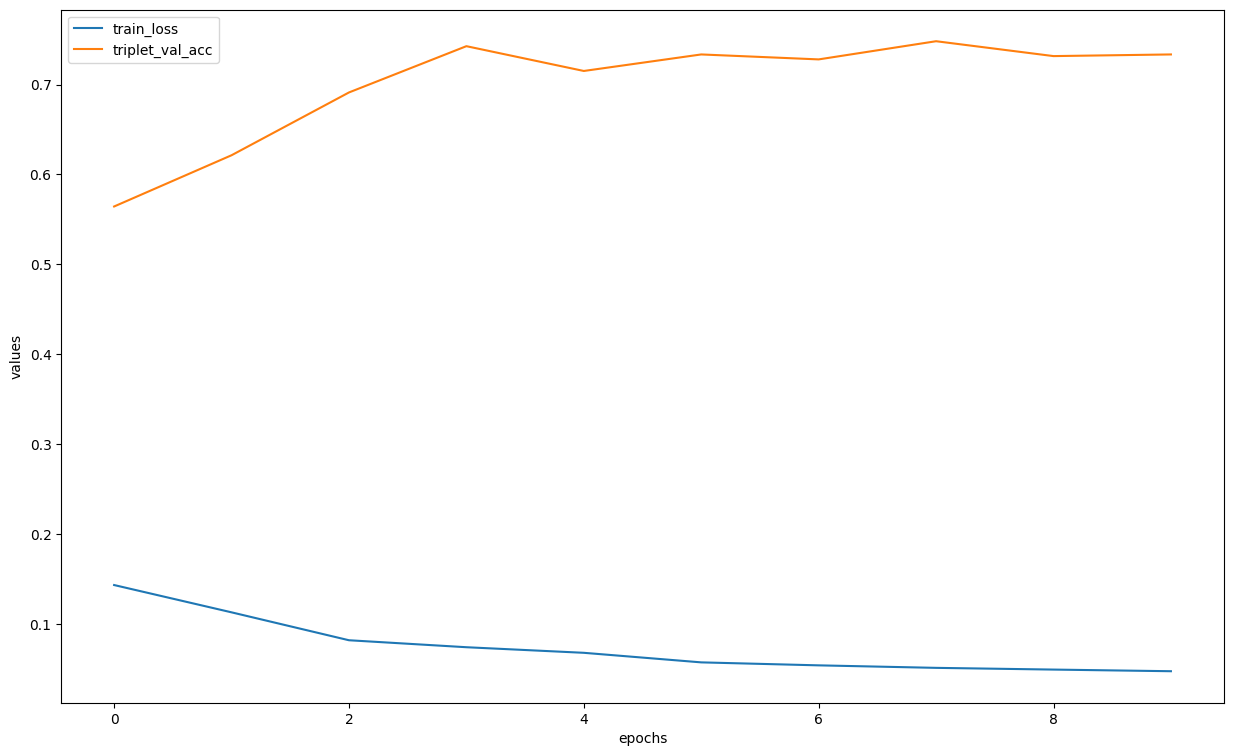

In [ ]:
plotHistory(history)

In [ ]:
# используя лучшую модель, посмотрим результаты на test
final_triplet_loss_model = copy.deepcopy(base_model)
final_triplet_loss_model = final_triplet_loss_model.to(device)
final_triplet_loss_model.load_state_dict(torch.load('best_classification_model_with_triplet_loss.pth'))
test_triplet_acc = test(final_triplet_loss_model, test_loader)
test_triplet_acc

0.7466887417218543

Для "наивной" реализации выбора anchor, positive, negative готово

Поcсмотрим, что будет, если получать anchor, positive, negative не случайным образом, а тем, что называется "semi hard", т.е. искать по батчу триплеты, удовлетворяющие опр критерию

In [ ]:
# реализация Dataset, точно такая же как и для ArcFace и CrossEntropy из соотв ноутбука
from PIL import Image

class FaceDatasetForSemiHardMining(Dataset):
    def __init__(self, images_dir, df_labels, mode='train'):
        self.images_dir = images_dir
        self.df_labels = df_labels
        self.mode = mode

    def __len__(self):
        return len(self.df_labels)

    def __getitem__(self, idx):
        img_name = self.df_labels.iloc[idx, 0]
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        label = self.df_labels.iloc[idx, 1]
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        if self.mode == 'val' or self.mode == 'test':
            image = transform_test(image)
        else:
            image = transform_train(image)

        return image, label

In [ ]:
# делим формируем DataSet и DataLoader точно также как и раньше
TRAIN_DIR = 'classification_data/train'
VAL_DIR = 'classification_data/val'
TEST_DIR = 'classification_data/test'

train_dataset_for_semi_hard_mining = FaceDatasetForSemiHardMining(TRAIN_DIR, train_identity_df, mode='train')
val_dataset_for_semi_hard_mining = FaceDatasetForSemiHardMining(VAL_DIR, val_identity_df, mode='val')
test_dataset_for_semi_hard_mining = FaceDatasetForSemiHardMining(TEST_DIR, test_identity_df, mode='test')

batch_size = 64
train_loader_for_semi_hard_mining = DataLoader(train_dataset_for_semi_hard_mining, batch_size=batch_size, shuffle=True)
val_loader_for_semi_hard_mining = DataLoader(val_dataset_for_semi_hard_mining, batch_size=batch_size, shuffle=False)
test_loader_for_semi_hard_mining = DataLoader(test_dataset_for_semi_hard_mining, batch_size=batch_size, shuffle=False)

In [ ]:
# функция для отбора триплетов по батчу так, чтобы d(A,P) < d(A,N), но d(A,P) + margin > d(A,N)
def semi_hard_triplet_mining(embeddings, labels, margin):
    distances = torch.cdist(embeddings, embeddings, p=2)
    num_samples = embeddings.size(0)
    triplets = []

    for anchor_idx in range(num_samples):
        anchor_label = labels[anchor_idx]

        positive_indices = torch.where(labels == anchor_label)[0]
        negative_indices = torch.where(labels != anchor_label)[0]

        positive_indices = positive_indices[positive_indices != anchor_idx]

        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue

        hardest_positive = positive_indices[distances[anchor_idx, positive_indices].argmax()]
        semi_hard_negatives = negative_indices[
            (distances[anchor_idx, negative_indices] > distances[anchor_idx, hardest_positive]) &
            (distances[anchor_idx, negative_indices] < distances[anchor_idx, hardest_positive] + margin)
        ]

        if len(semi_hard_negatives) > 0:
            hardest_negative = semi_hard_negatives[distances[anchor_idx, semi_hard_negatives].argmin()]
            triplets.append((anchor_idx, hardest_positive.item(), hardest_negative.item()))

    return triplets

# функция для подсчета Triplet_Accuracy по батчу для semi hard
def batch_triplet_accuracy(embeddings, labels, margin):
    distances = torch.cdist(embeddings, embeddings)
    batch_size = embeddings.size(0)
    correct = 0
    total = 0

    # для каждого эмбединга, вычисляем позитивные и негативные и ищем среди них те, что удовл d(A,P) + margin < d(A,N)
    for i in range(batch_size):
        anchor_label = labels[i]

        positive_indices = torch.where(labels == anchor_label)[0]
        negative_indices = torch.where(labels != anchor_label)[0]
        positive_indices = positive_indices[positive_indices != i]

        if len(positive_indices) == 0 or len(negative_indices) == 0:
            continue

        for p in positive_indices:
            d_ap = distances[i, p].item()
            for n in negative_indices:
                d_an = distances[i, n].item()
                if d_ap + margin < d_an:
                    correct += 1
                total += 1

    return correct / total if total > 0 else 0

# функция для расчета Recall@K(понаблюдаем и за этой метрикой тоже)
def recall_at_k(embeddings, labels, k=1):
    distances = torch.cdist(embeddings, embeddings)
    sorted_indices = distances.argsort(dim=1)
    top_k = sorted_indices[:, 1:k+1]

    correct = (labels[top_k] == labels.unsqueeze(1)).any(dim=1)
    return correct.float().mean().item()

# функция для обучения эпохи
def fit_epoch_for_semi_hard_mining(model, train_loader, optimizer, criterion, margin=0.2):
    model.train()
    epoch_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        embeddings = model(images)
        embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
        # формируем триплеты способом semi_hard, чтобы учить на них loss
        triplets = semi_hard_triplet_mining(embeddings, labels, margin)

        if len(triplets) == 0:
            continue

        anchor = torch.stack([embeddings[a] for a, _, _ in triplets])
        positive = torch.stack([embeddings[p] for _, p, _ in triplets])
        negative = torch.stack([embeddings[n] for _, _, n in triplets])

        loss = criterion(anchor, positive, negative)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

# функция для валидации эпохи, считаем и Recall@1 и TripletAccuracy
def eval_epoch_for_semi_hard_mining(model, val_loader, margin=0.2):
    model.eval()
    batches = 0
    total_batch_accuracy = 0
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
            all_embeddings.append(embeddings)
            all_labels.append(labels)
            batch_accuracy = batch_triplet_accuracy(embeddings, labels, margin)
            total_batch_accuracy += batch_accuracy
            batches += 1

    avg_triplet_accuracy = total_batch_accuracy / batches
    embeddings = torch.cat(all_embeddings)
    labels = torch.cat(all_labels)

    recall1 = recall_at_k(embeddings, labels, k=1)

    global best_accuracy
    if avg_triplet_accuracy > best_accuracy:
        best_accuracy = avg_triplet_accuracy
        torch.save(model.state_dict(), "best_classification_model_with_semi_hard_mining_triplet_loss.pth")
        print(f"Model saved with accuracy {avg_triplet_accuracy:.4f}")

    return avg_triplet_accuracy, recall1

from torch.optim.lr_scheduler import StepLR

# обучение модели
def train_for_semi_hard_mining(model, train_loader, val_loader, optimizer, criterion, epochs, batch_size, margin=0.2):
    history = []
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5)

    for epoch in range(epochs):
        train_loss = fit_epoch_for_semi_hard_mining(model, train_loader, optimizer, criterion, margin=margin)
        triplet_val_acc, recall1 = eval_epoch_for_semi_hard_mining(model, val_loader, margin=margin)
        history.append((train_loss, triplet_val_acc))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, triplet_val_acc: {triplet_val_acc:.4f}, recall1: {recall1:.4f}")
        scheduler.step()

    return history


# функция для тестирования модели. Тут будем считать только TripletAccuracy, чтобы сравнить с предыдущей моделью, где триплеты выбирались случайно
def test_for_hard_mining(model, test_loader):
    model.eval()
    processed_size = 0
    total_correct_triplets = 0
    batches = 0
    total_batch_accuracy = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            embeddings = nn.functional.normalize(embeddings, p=2, dim=1)
            batch_accuracy = batch_triplet_accuracy(embeddings, labels, margin)
            total_batch_accuracy += batch_accuracy
            batches += 1
    avg_triplet_accuracy = total_batch_accuracy / batches

    return avg_triplet_accuracy

In [ ]:
epochs = 10
model2 = copy.deepcopy(base_model)
model2 = model2.to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.001, weight_decay=1e-4)
margin = 0.2
criterion = TripletLoss(margin=margin)
best_accuracy = 0.0
history2 = train_for_semi_hard_mining(model2, train_loader_for_semi_hard_mining, val_loader_for_semi_hard_mining, optimizer, criterion, epochs, batch_size, margin=margin)

Model saved with accuracy 0.5475
Epoch 1/10, Train Loss: 0.1633, triplet_val_acc: 0.5475, recall1: 0.0294
Epoch 2/10, Train Loss: 0.1622, triplet_val_acc: 0.3922, recall1: 0.0294
Model saved with accuracy 0.5800
Epoch 3/10, Train Loss: 0.1619, triplet_val_acc: 0.5800, recall1: 0.0294
Epoch 4/10, Train Loss: 0.1602, triplet_val_acc: 0.5510, recall1: 0.0386
Model saved with accuracy 0.5875
Epoch 5/10, Train Loss: 0.1603, triplet_val_acc: 0.5875, recall1: 0.0404
Model saved with accuracy 0.6193
Epoch 6/10, Train Loss: 0.1598, triplet_val_acc: 0.6193, recall1: 0.0607
Model saved with accuracy 0.6395
Epoch 7/10, Train Loss: 0.1598, triplet_val_acc: 0.6395, recall1: 0.0496
Model saved with accuracy 0.6816
Epoch 8/10, Train Loss: 0.1589, triplet_val_acc: 0.6816, recall1: 0.0496
Model saved with accuracy 0.6878
Epoch 9/10, Train Loss: 0.1555, triplet_val_acc: 0.6878, recall1: 0.0551
Model saved with accuracy 0.6980
Epoch 10/10, Train Loss: 0.1568, triplet_val_acc: 0.6980, recall1: 0.0588


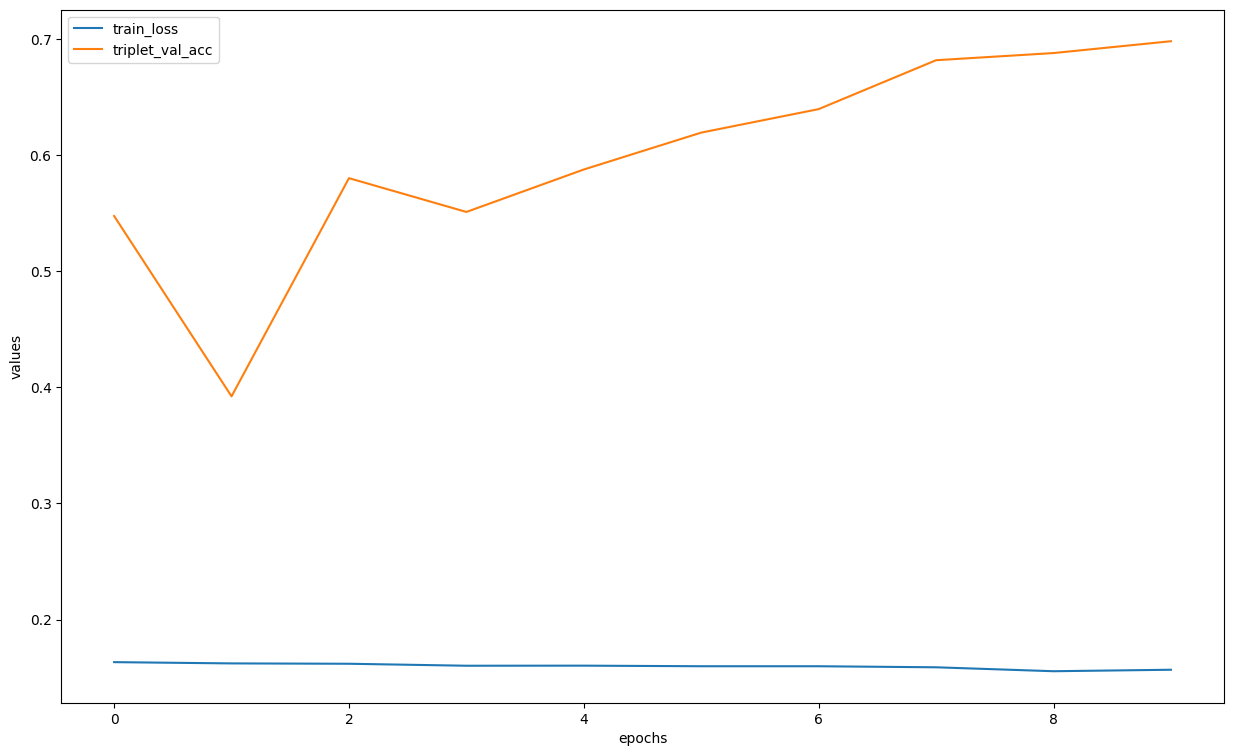

In [ ]:
plotHistory(history2)

In [ ]:
# используя лучшую модель, посмотрим результаты на test
final_hard_mining_triplet_loss_model = copy.deepcopy(base_model)
final_hard_mining_triplet_loss_model = final_hard_mining_triplet_loss_model.to(device)
final_hard_mining_triplet_loss_model.load_state_dict(torch.load('best_classification_model_with_semi_hard_mining_triplet_loss.pth'))
test_hard_mining_triplet_acc = test_for_hard_mining(final_hard_mining_triplet_loss_model, test_loader_for_semi_hard_mining)
test_hard_mining_triplet_acc

0.7316267871913034

Для Semi Hard Mining готово. Хотя в этом случае, вроде как triplet accuracy не считается хорошей метрикой и по ней результаты получились хуже. Также видно что recall1 плохой. Скорее всего нужно увеличить размер батча для лучшего майнинга триплетов и учить как то хитрее